<a href="https://colab.research.google.com/github/Nilufayeasmin299/Reproduce-GNN_Ownership_Verification/blob/main/Final_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch torchvision torch-geometric numpy scikit-learn matplotlib tqdm


In [11]:
# Import Libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid, Amazon
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, BatchNorm
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


In [12]:
# Hyperparameter Configuration
CONFIG = {
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'hidden_dim': 128,
    'dropout': 0.5,
    'epochs': 300,
    'edge_dropout_rate': 0.1,
    'mask_ratios': [0.0, 0.05, 0.1, 0.2]
}


In [13]:
def create_masks(data, train_ratio=0.6, val_ratio=0.2):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:train_size]] = True
    data.val_mask[indices[train_size:train_size + val_size]] = True
    data.test_mask[indices[train_size + val_size:]] = True
    return data


In [14]:
def normalize_features(data):
    data.x = F.normalize(data.x, p=2, dim=1)  # L2 normalization
    return data


In [15]:
def augment_data(data, edge_dropout_rate):
    num_edges = data.edge_index.shape[1]
    keep_edges = int(num_edges * (1 - edge_dropout_rate))
    perm = torch.randperm(num_edges)[:keep_edges]
    data.edge_index = data.edge_index[:, perm]
    return data


In [16]:
def mask_features(data, mask_ratio):
    num_features = data.x.shape[1]
    num_mask = int(num_features * mask_ratio)
    mask_indices = random.sample(range(num_features), num_mask)

    masked_x = data.x.clone()
    masked_x[:, mask_indices] = 0
    data.x = masked_x
    return data


In [17]:
class AdvancedGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AdvancedGNN, self).__init__()
        self.conv1 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(in_channels, CONFIG['hidden_dim']),
                BatchNorm(CONFIG['hidden_dim']),
                torch.nn.ReLU(),
                torch.nn.Linear(CONFIG['hidden_dim'], CONFIG['hidden_dim']),
            )
        )
        self.conv2 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(CONFIG['hidden_dim'], CONFIG['hidden_dim']),
                BatchNorm(CONFIG['hidden_dim']),
                torch.nn.ReLU(),
                torch.nn.Linear(CONFIG['hidden_dim'], CONFIG['hidden_dim']),
            )
        )
        self.fc = torch.nn.Linear(CONFIG['hidden_dim'], out_channels)
        self.dropout = torch.nn.Dropout(p=CONFIG['dropout'])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [18]:
def train_gnn(model, data, optimizer, criterion, edge_dropout_rate):
    model.train()
    optimizer.zero_grad()

    # Augment data
    augmented_data = augment_data(data.clone(), edge_dropout_rate)
    out = model(augmented_data)

    loss = criterion(out[augmented_data.train_mask], augmented_data.y[augmented_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_gnn(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        accuracy = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

        cm = confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
        fpr = 1 - np.diag(cm) / cm.sum(axis=1)
        fnr = 1 - np.diag(cm) / cm.sum(axis=0)
        avg_fpr = np.mean(fpr)
        avg_fnr = np.mean(fnr)
    return accuracy, avg_fpr, avg_fnr


In [20]:
datasets = {
    'Cora': Planetoid(root='/tmp/Cora', name='Cora'),
    'CiteSeer': Planetoid(root='/tmp/CiteSeer', name='CiteSeer'),
    'PubMed': Planetoid(root='/tmp/PubMed', name='PubMed')
}
RESULTS = {}

for dataset_name, dataset in tqdm(datasets.items(), desc="Running Experiments"):
    data = dataset[0]
    data = normalize_features(data)
    data = create_masks(data)

    in_channels = data.num_features
    out_channels = dataset.num_classes

    for mask_ratio in CONFIG['mask_ratios']:
        print(f"Evaluating {dataset_name} with Mask Ratio {mask_ratio}")
        masked_data = mask_features(data.clone(), mask_ratio)

        model = AdvancedGNN(in_channels, out_channels).to('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
        criterion = torch.nn.CrossEntropyLoss()

        # In the training loop within your main experiment block:
        for epoch in range(CONFIG['epochs']):
          masked_data = masked_data.to(model.conv1.nn[0].weight.device) # Move data to the device where model weights reside
          loss = train_gnn(model, masked_data, optimizer, criterion, CONFIG['edge_dropout_rate'])
          if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

        accuracy, avg_fpr, avg_fnr = evaluate_gnn(model, masked_data)
        RESULTS[f"{dataset_name}_mask_{mask_ratio}"] = {
            'Accuracy': accuracy,
            'FPR': avg_fpr,
            'FNR': avg_fnr
        }
        print(f"Accuracy: {accuracy:.4f}, FPR: {avg_fpr:.4f}, FNR: {avg_fnr:.4f}")


Running Experiments:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating Cora with Mask Ratio 0.0
Epoch 0: Loss = 1.9773
Epoch 50: Loss = 0.1273
Epoch 100: Loss = 0.0329
Epoch 150: Loss = 0.0296
Epoch 200: Loss = 0.0219
Epoch 250: Loss = 0.0141
Accuracy: 0.8435, FPR: 0.1600, FNR: 0.1677
Evaluating Cora with Mask Ratio 0.05
Epoch 0: Loss = 1.9630
Epoch 50: Loss = 0.1089
Epoch 100: Loss = 0.0387
Epoch 150: Loss = 0.0217
Epoch 200: Loss = 0.0139
Epoch 250: Loss = 0.0138
Accuracy: 0.8545, FPR: 0.1449, FNR: 0.1547
Evaluating Cora with Mask Ratio 0.1
Epoch 0: Loss = 1.9880
Epoch 50: Loss = 0.1255
Epoch 100: Loss = 0.0413
Epoch 150: Loss = 0.0236
Epoch 200: Loss = 0.0159
Epoch 250: Loss = 0.0173
Accuracy: 0.8379, FPR: 0.1619, FNR: 0.1703
Evaluating Cora with Mask Ratio 0.2
Epoch 0: Loss = 1.9759
Epoch 50: Loss = 0.1213
Epoch 100: Loss = 0.0420
Epoch 150: Loss = 0.0290
Epoch 200: Loss = 0.0224
Epoch 250: Loss = 0.0141


Running Experiments:  33%|███▎      | 1/3 [00:06<00:13,  6.56s/it]

Accuracy: 0.8361, FPR: 0.1646, FNR: 0.1749
Evaluating CiteSeer with Mask Ratio 0.0
Epoch 0: Loss = 1.7989
Epoch 50: Loss = 0.1513
Epoch 100: Loss = 0.0918
Epoch 150: Loss = 0.0714
Epoch 200: Loss = 0.0665
Epoch 250: Loss = 0.0615
Accuracy: 0.7162, FPR: 0.3068, FNR: 0.3033
Evaluating CiteSeer with Mask Ratio 0.05
Epoch 0: Loss = 1.8315
Epoch 50: Loss = 0.1578
Epoch 100: Loss = 0.0969
Epoch 150: Loss = 0.0690
Epoch 200: Loss = 0.0588
Epoch 250: Loss = 0.0532
Accuracy: 0.6967, FPR: 0.3216, FNR: 0.3243
Evaluating CiteSeer with Mask Ratio 0.1
Epoch 0: Loss = 1.8131
Epoch 50: Loss = 0.1567
Epoch 100: Loss = 0.0873
Epoch 150: Loss = 0.0691
Epoch 200: Loss = 0.0747
Epoch 250: Loss = 0.0534
Accuracy: 0.7132, FPR: 0.3116, FNR: 0.3111
Evaluating CiteSeer with Mask Ratio 0.2
Epoch 0: Loss = 1.7838
Epoch 50: Loss = 0.1412
Epoch 100: Loss = 0.0903
Epoch 150: Loss = 0.0699
Epoch 200: Loss = 0.0596
Epoch 250: Loss = 0.0513


Running Experiments:  67%|██████▋   | 2/3 [00:16<00:08,  8.65s/it]

Accuracy: 0.7027, FPR: 0.3128, FNR: 0.3135
Evaluating PubMed with Mask Ratio 0.0
Epoch 0: Loss = 1.0908
Epoch 50: Loss = 0.2725
Epoch 100: Loss = 0.1342
Epoch 150: Loss = 0.0693
Epoch 200: Loss = 0.0388
Epoch 250: Loss = 0.0273
Accuracy: 0.8699, FPR: 0.1313, FNR: 0.1382
Evaluating PubMed with Mask Ratio 0.05
Epoch 0: Loss = 1.1334
Epoch 50: Loss = 0.2821
Epoch 100: Loss = 0.1492
Epoch 150: Loss = 0.0725
Epoch 200: Loss = 0.0442
Epoch 250: Loss = 0.0314
Accuracy: 0.8689, FPR: 0.1336, FNR: 0.1393
Evaluating PubMed with Mask Ratio 0.1
Epoch 0: Loss = 1.0884
Epoch 50: Loss = 0.2880
Epoch 100: Loss = 0.1471
Epoch 150: Loss = 0.0753
Epoch 200: Loss = 0.0490
Epoch 250: Loss = 0.0367
Accuracy: 0.8616, FPR: 0.1428, FNR: 0.1466
Evaluating PubMed with Mask Ratio 0.2
Epoch 0: Loss = 1.1119
Epoch 50: Loss = 0.2944
Epoch 100: Loss = 0.1629
Epoch 150: Loss = 0.0866
Epoch 200: Loss = 0.0563
Epoch 250: Loss = 0.0381


Running Experiments: 100%|██████████| 3/3 [00:34<00:00, 11.58s/it]

Accuracy: 0.8616, FPR: 0.1392, FNR: 0.1455


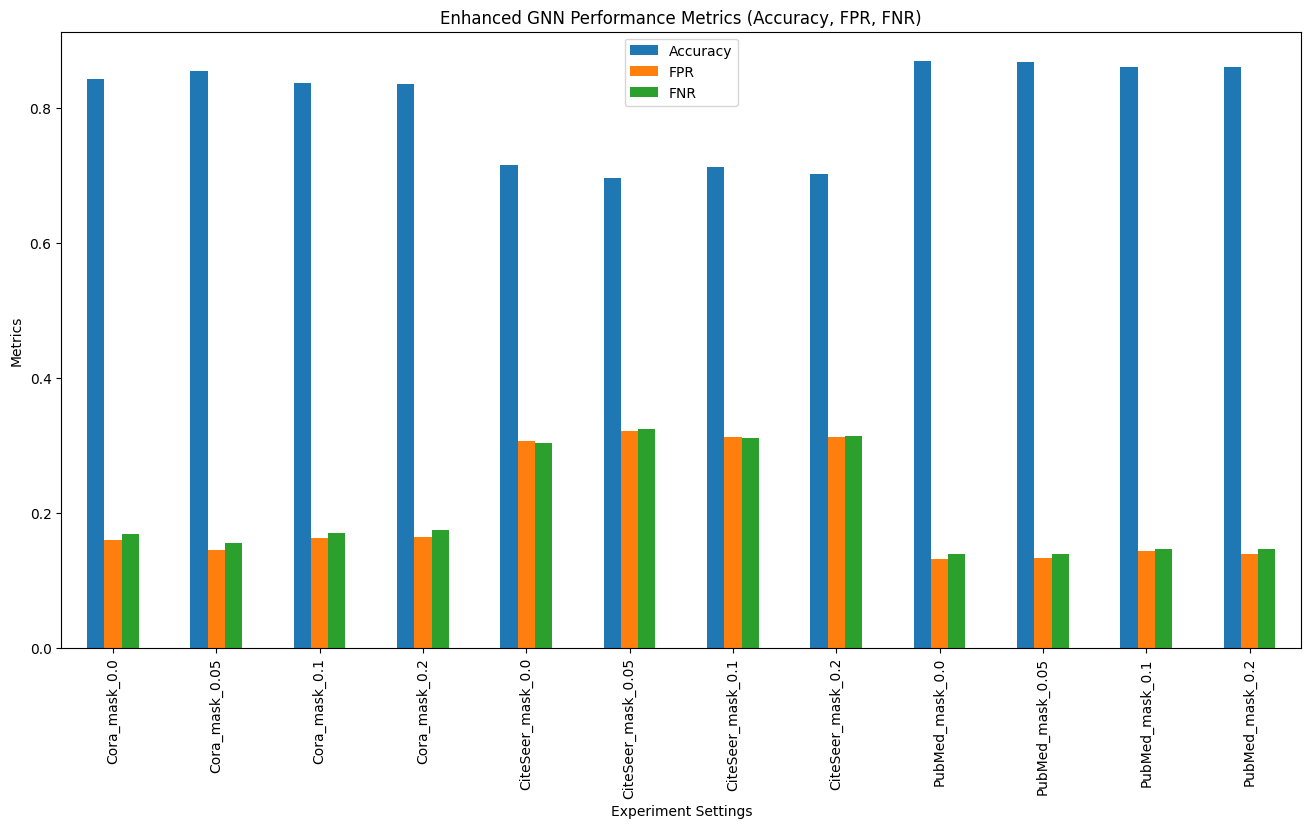

In [21]:
# Visualize Results
result_df = pd.DataFrame.from_dict(RESULTS, orient='index')
result_df.style.format("{:.4f}")

result_df.plot(kind='bar', figsize=(16, 8))
plt.title("Enhanced GNN Performance Metrics (Accuracy, FPR, FNR)")
plt.xlabel("Experiment Settings")
plt.ylabel("Metrics")
plt.legend(["Accuracy", "FPR", "FNR"])
plt.show()
